P-ARAM: 2.00, P-BR: 0.30
STEP 0: D:1.386 G:0.676
STEP 3000: D:1.392 G:0.694
STEP 6000: D:1.383 G:0.693
STEP 9000: D:1.377 G:0.702
STEP 12000: D:1.397 G:0.689


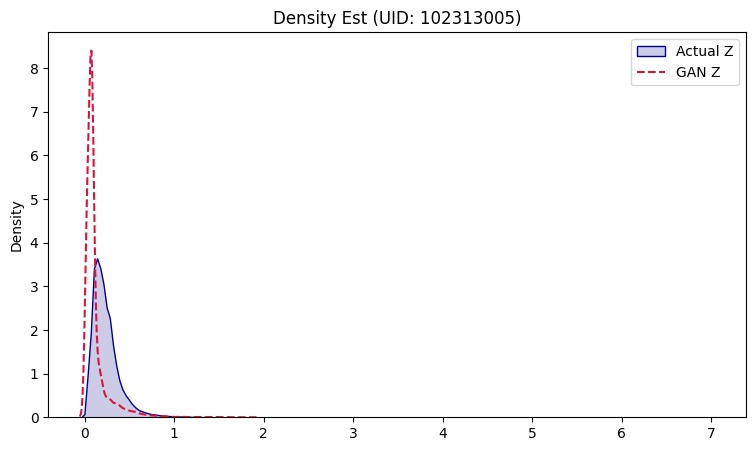

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as opt
import matplotlib.pyplot as plt
import seaborn as sns

UID = 102313005
SRC = '/content/data.csv'

A_VAL = 0.5 * (UID % 7)
B_VAL = 0.3 * (UID % 5 + 1)

print(f"P-ARAM: {A_VAL:.2f}, P-BR: {B_VAL:.2f}")

raw_df = pd.read_csv(SRC, low_memory=False, encoding='latin-1')
vec_x = pd.to_numeric(raw_df['no2'], errors='coerce').dropna().values
v_min, v_max = vec_x.min(), vec_x.max()
norm_x = (vec_x - v_min) / (v_max - v_min) * 5

z_obs = norm_x + A_VAL * np.sin(B_VAL * norm_x)
z_tensor = torch.FloatTensor(z_obs).reshape(-1, 1)

class PDFGen(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(1, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        return self.main(x)

class PDFDisc(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(1, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x)

mG, mD = PDFGen(), PDFDisc()
optG = opt.Adam(mG.parameters(), lr=1e-4, betas=(0.5, 0.9))
optD = opt.Adam(mD.parameters(), lr=1e-4, betas=(0.5, 0.9))
loss_fn = nn.BCELoss()

iters = 15000
sz = 64

for i in range(iters):
    mD.zero_grad()
    pick = torch.randint(0, len(z_tensor), (sz,))
    real_b = z_tensor[pick]
    lbl_r = torch.ones(sz, 1)

    out_r = mD(real_b)
    errD_r = loss_fn(out_r, lbl_r)

    latent = torch.randn(sz, 1)
    fake_b = mG(latent)
    lbl_f = torch.zeros(sz, 1)
    out_f = mD(fake_b.detach())
    errD_f = loss_fn(out_f, lbl_f)

    (errD_r + errD_f).backward()
    optD.step()

    mG.zero_grad()
    out_g = mD(fake_b)
    errG = loss_fn(out_g, lbl_r)
    errG.backward()
    optG.step()

    if i % 3000 == 0:
        print(f"STEP {i}: D:{errD_r+errD_f:.3f} G:{errG:.3f}")

mG.eval()
with torch.no_grad():
    res_z = mG(torch.randn(10000, 1)).numpy()

plt.figure(figsize=(9, 5))
sns.kdeplot(z_obs, label='Actual Z', color='darkblue', fill=True, alpha=0.2)
sns.kdeplot(res_z.flatten(), label='GAN Z', color='crimson', ls='--')
plt.title(f"Density Est (UID: {UID})")
plt.legend()
plt.show()